# PVRW Poster Plots

The code below is the first version of the calculator coded by Tim Silverman. It does not use the functions established in the CE-MFC Repository, but rather the code that informs those functions is explicitly included here. Plots have been modified and prettied-up, and were published in:

> S. Ayala Pelaez, H. Mirletz, T. Silverman, A. Carpenter, T. Barnes. "De-fluffing circular economy metrics with open-source calculator for PV," PV Reliability Workshop 2020 (proceedings forthcoming).



# Preamble and definitions

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline



In [26]:

font = {'family' : 'arial',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [27]:
def weibull_params(keypoints):
    '''Returns shape parameter `alpha` and scale parameter `beta`
    for a Weibull distribution whose CDF passes through the
    two time: value pairs in `keypoints`'''
    t1, t2 = tuple(keypoints.keys())
    cdf1, cdf2 = tuple(keypoints.values())
    alpha = np.asscalar(np.real_if_close(
        (np.log(np.log(1 - cdf1)+0j) - np.log(np.log(1 - cdf2)+0j))/(np.log(t1) - np.log(t2))
    ))
    beta = np.abs(np.exp(
        (
            np.log(t2)*((0+1j)*np.pi + np.log(np.log(1 - cdf1)+0j))
            + np.log(t1)*(((0-1j))*np.pi - np.log(np.log(1 - cdf2)+0j))
        )/(
            np.log(np.log(1 - cdf1)+0j) - np.log(np.log(1 - cdf2)+0j)
        )
    ))
    return {'alpha': alpha, 'beta': beta}

In [28]:
def weibull_cdf(alpha, beta):
    '''Return the CDF for a Weibull distribution having:
    shape parameter `alpha`
    scale parameter `beta`'''
    def cdf(x):
        return 1 - np.exp(-(np.array(x)/beta)**alpha)
    return cdf

# Waste projection

### Dangerous assumptions (which need to be fixed or explained before publication) are marked with 'warning'

## Inputs

In [30]:
# The simulation is for this range of years
df = pd.DataFrame(index=np.arange(1995, 2024+1, 1))

### Installed capacity

In [31]:
# US annual installed capacity (watts)
# prior to 2010 is from Report IEA-PVPS T1-19:2010
# after 2010 is from Q4 2019 Wood Mackenzie Power & Renewables/SEIA U.S. Solar Market Insight
df['new_capacity_total'] = np.array([9.0, 9.7, 11.7, 11.9, 17.2, 21.5, 29.0, 44.4, 63.0, 100.8, 103.0, 145.0, 206.5, 338.0, 473.1, 849, 1921, 3373, 4766, 6244, 7501, 15152, 10845, 10790, 13352, 14904, 16456, 15227, 15224, 16634])*1e6

# that capacity includes non-crystalline-silicon, so needs to be derated by market share

# global market share numbers from 2018-2019 Photovoltaic Manufacturer Capacity, Shipments, Price & Revenues (SPV Market Research)
# warning: assuming that US market share is the same as the global market share
# warning: assuming, with a lack of data and to be conservative, that everything installed before 2008 was p-type mono-Si
# in the source, 'mono' includes n- and p-type
share_mono = np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 35, 35, 37, 38, 37, 36, 39, 35, 41, 45, 45, 59.85, 64.125, 68.4, 71.25, 74.1, 76.95])/100
# mono was 18% n-type in 2018
# warning: blindly extending this back to 2010, which is incorrect
share_ntype = share_mono*np.array([ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 18, 18, 18, 18, 18, 18, 18, 18, 17.46031746, 19.84126984, 22.22222222, 25.21367521, 28.20512821, 31.1965812])/100
# warning: assuming that there was no multi before 2008
share_multi = np.array([ 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 49, 46, 48, 48, 52, 55, 55, 58, 54, 51, 51, 35.15, 30.875, 26.6, 23.75, 20.9, 18.05])/100

share_silicon = share_mono + share_multi

# here 'silicon' means 'crystalline silicon'
df['new_capacity_silicon'] = df['new_capacity_total']*share_silicon

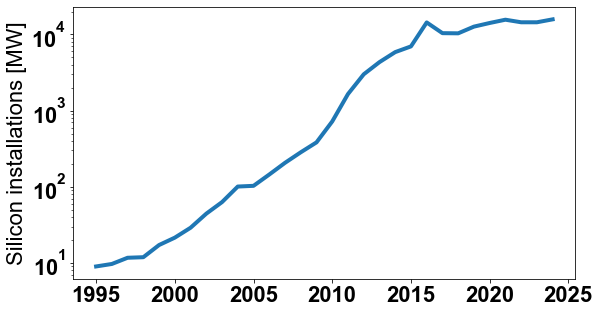

In [32]:
# Plotting Installed Capacity of Silicon

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['new_capacity_silicon']/1e6, linewidth=4)
plt.ylabel('Silicon installations [MW]')
ax.set_yscale('log')
pass

### PROJECTING CAPACITY

To project capacity into the future without economic, policy or behavior analysis:
assume cumulative capacity follows a logistic sigmoid function:
capacityscale/(1 + np.exp(-timescale * (-midtime + t)))
these parameters fit well:

capacityscale: 8.44466e10
timescale: 0.560261
midtime: 2016.45

his is kind of pessimistic, saying annual installations began slowing down permanently in 2016 and we'll only ever have a total of 84 GW installed in the US
Cutting off the last two years changes the parameters so we get >400 GW installed with a 2021 turning point

### Efficiency and area

In [33]:
# estimating efficiency
# global numbers from 2018-2019 Photovoltaic Manufacturer Capacity, Shipments, Price & Revenues (SPV Market Research)
# warning: these may be averaged across products available, not averaged across what was sold
# warning: prior to 2008 the numbers are based on linear extrapolations
efficiency_ntype = np.array([9.5, 10.1, 10.7, 11.2, 11.8, 12.4, 13, 13.6, 14.1, 14.7, 15.3, 15.9, 16.5, 17.45, 17.92, 18.04, 18.45, 19.2, 19.89, 20.2, 20.75, 21.2, 22.9, 23.2, 23.51, 23.82, 24.13, 24.44, 24.75, 25.06])/100
efficiency_mono = np.array([6.4, 6.9, 7.5, 8, 8.5, 9, 9.6, 10.1, 10.6, 11.1, 11.6, 12.2, 12.7, 13.45, 13.7, 14.1, 14.79, 15.1, 15.85, 16.5, 16.9, 17.3, 18.1, 18.4, 19.05, 19.7, 20.35, 21, 21.65, 22.3])/100
efficiency_multi = np.array([7.1, 7.5, 8, 8.4, 8.8, 9.3, 9.7, 10.1, 10.6, 11, 11.4, 11.9, 12.3, 13.01, 13.2, 13.7, 13.86, 14.5, 14.9, 15.1, 15.5, 16.2, 17.1, 17.2, 17.4, 17.6, 17.8, 18, 18.2, 18.4])/100
# weighted average efficiency
efficiency_aggregate = (
    ((share_mono - share_ntype)*efficiency_mono + share_ntype*efficiency_ntype + share_multi*efficiency_multi)/(share_mono + share_multi)
)
df['efficiency'] = efficiency_aggregate

# area of all PV installed each year (m^2)
irradiance_stc = 1000 # W/m^2
df['area'] = df['new_capacity_silicon']/df['efficiency']/irradiance_stc # m^2

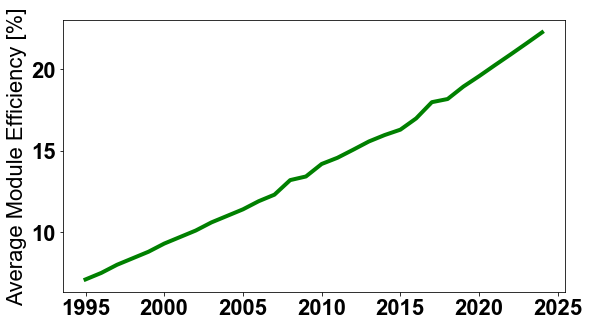

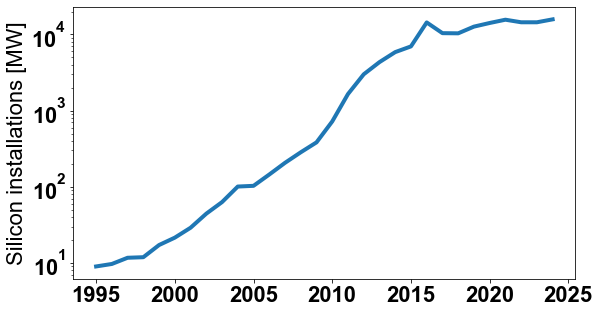

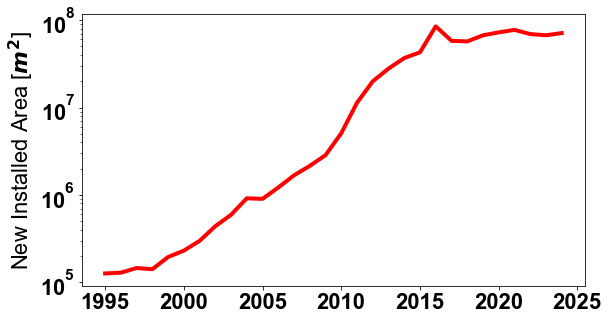

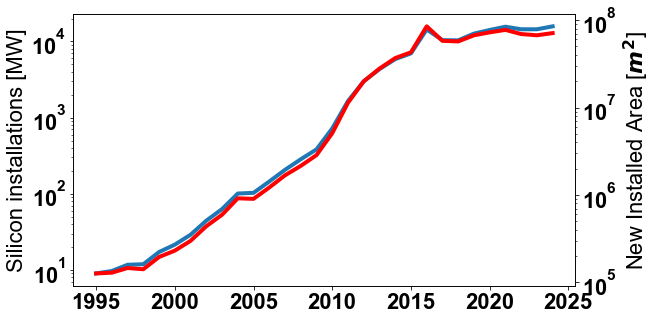

In [34]:
# Ploting Silicon Installations vs New Installed Area

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['efficiency']*100, 'g', linewidth=4)
plt.ylabel('Average Module Efficiency [%]')


fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['new_capacity_silicon']/1e6, linewidth=4)
plt.ylabel('Silicon installations [MW]')
ax.set_yscale('log')

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['area'], 'r', linewidth=4)
plt.ylabel('New Installed Area [$m^2$]')
ax.set_yscale('log')
plt.show()

fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['new_capacity_silicon']/1e6, linewidth=4)
plt.ylabel('Silicon installations [MW]')
ax.set_yscale('log')

ax2=ax.twinx()
ax2.plot(df.index, df['area'], 'r', linewidth=4)
ax2.set_ylabel('New Installed Area [$m^2$]')
ax2.set_yscale('log')
plt.show()

pass

### Component mass

In [35]:
# mass of glass
# for now, assume that everything uses the equivalent of a single piece of glass of the same thickness
# warning: as of recently, this isn't true anymore and needs to be quantified (check ITRPV 2019 for future projections)
density_glass = 2500 # kg/m^3
thickness_glass = 3.5e-3 # m
print("Weight per m2 of glass ", thickness_glass*density_glass)
# in kg
df['mass_glass'] = df['area']*thickness_glass*density_glass

# mass of silver
# use past ITRPV predictions (read by eye from fig 65 in ITRPV 2019)
# warning: these aren't real data, they are industry predictions, but sometimes predictions for the current year
# warning: prior to 2009 these are extrapolations based on a linear fit
# in kg per cell
df['mass_silver_per_cell'] = np.array([0.85, 0.8, 0.8, 0.75, 0.7, 0.65, 0.65, 0.6, 0.55, 0.5, 0.5, 0.45, 0.4, 0.35, 0.4, 0.3, 0.25, 0.2, 0.15, 0.1, 0.1, 0.1, 0.1, 0.1, 0.09, 0.08, 0.075, 0.06, 0.065, 0.05])/1000
# warning: assume cell efficiency equals module efficiency (not always true)
# warning: assume all cells are 156-mm squares (probably mostly true for 2010–2019, not super true outside of this)
area_cell = 0.156**2
df['n_cells'] = df['area']/area_cell
# in kg
df['mass_silver'] = df['mass_silver_per_cell']*df['n_cells']

# warning: need do the same thing for silicon, copper, etc.

Weight per m2 of glass  8.75


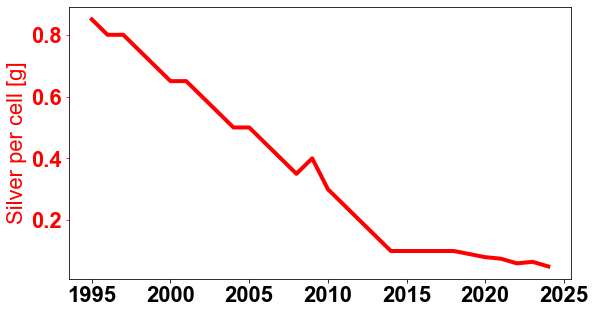

In [36]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['mass_silver_per_cell']*1000, 'r', label='Silver', linewidth=4)
ax.set_ylabel('Silver per cell [g]', color='r')
ax.tick_params(axis='y', colors='r')


## Mass of GLASS
(Still in development)

## New Installed Material Plots

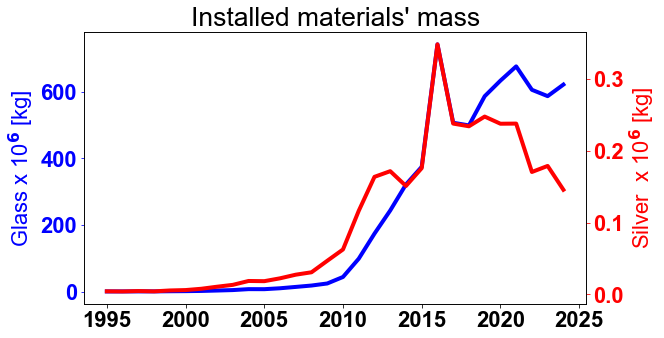

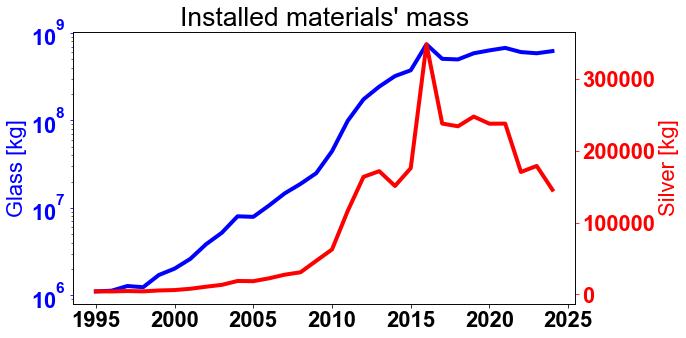

In [38]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['mass_glass']/1000000, color='blue', label='Glass', linewidth=4)
ax.set_ylabel('Glass x 10$^6$ [kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
ax2=ax.twinx()
plt.title("Installed materials' mass")
ax2.plot(df.index, df['mass_silver']/1000000, 'r', label='Silver', linewidth=4)
ax2.set_ylabel('Silver  x 10$^6$ [kg]', color='red')
ax2.tick_params(axis='y', colors='red')


fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['mass_glass'], color='blue', label='Glass', linewidth=4)
ax.set_ylabel('Glass [kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
ax.set_yscale('log')
ax2=ax.twinx()
plt.title("Installed materials' mass")
ax2.plot(df.index, df['mass_silver'], 'r', label='Silver', linewidth=4)
ax2.set_ylabel('Silver [kg]', color='red')
ax2.tick_params(axis='y', colors='red')
ax.set_yscale('log')
pass



### Reliability

In [39]:
# warning: these are wild guesses
# T50: years until 90% of that year's cohort has been disposed
# T90: years until 99% of that year's cohort has been disposed
df['t50'] = [15, 15, 16, 16, 17, 17, 18, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 22, 23, 23, 24, 24, 25, 25, 25, 25, 25, 30, 30, 30]
df['t90'] = [20, 20, 21, 21, 22, 22, 23, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 27, 28, 28, 29, 29, 30, 30, 30, 30, 37.5, 37.5, 37.5, 37.5]

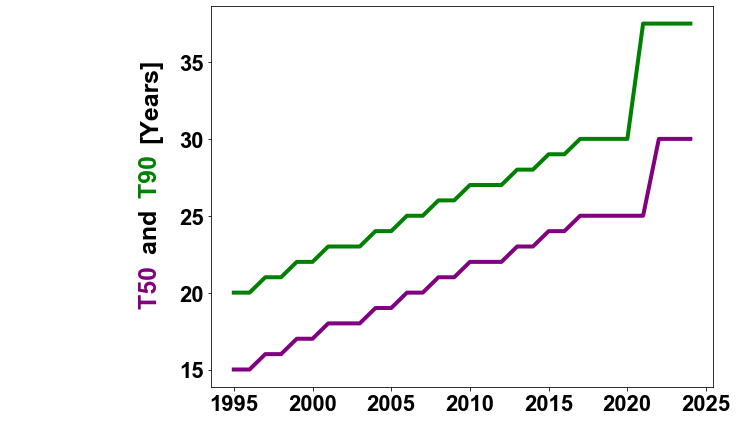

In [40]:
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker, VPacker

fig, ax = plt.subplots(figsize=(9, 7))
plt.plot(df.index, df['t50'], color='purple', label='t50', linewidth=4)
plt.plot(df.index, df['t90'], color='green', label='t90', linewidth=4)
#ax.set_ylabel('T50 (Median Time to Fail) and T90 [Years]')

ybox1 = TextArea("T50 ", textprops=dict(color="purple", size=25,rotation=90,ha='left',va='bottom'))
ybox2 = TextArea("and ",     textprops=dict(color="black", size=25,rotation=90,ha='left',va='bottom'))
ybox3 = TextArea("T90 ", textprops=dict(color="green", size=25,rotation=90,ha='left',va='bottom'))
ybox4 = TextArea("[Years]",     textprops=dict(color="black", size=25,rotation=90,ha='left',va='bottom'))

ybox = VPacker(children=[ybox4, ybox3, ybox2, ybox1],align="bottom", pad=-155, sep=5)

anchored_ybox = AnchoredOffsetbox(loc=8, child=ybox, pad=0., frameon=False, bbox_to_anchor=(-0.12, 0.6), 
                                  bbox_transform=ax.transAxes, borderpad=0.)

ax.add_artist(anchored_ybox)


pass


## Eliminating Modules through Weibull


In [41]:
df['disposal_function'] = [
    weibull_cdf(**weibull_params({t50: 0.5, t90: 0.9}))
    for t50, t90
    in zip(df['t50'], df['t90'])
]

### Example: Calculating Weibull Parameters

In [42]:
test_t50 = 30
test_t90 = 25
test = weibull_params({test_t50: 0.50, test_t90: 0.90})
print("WEIBULL Parameters for a t50 and t90 of ", test_t50, " & ", test_t90, " years are Alpha: ", test['alpha'], " Beta: ", test['beta'])


WEIBULL Parameters for a t50 and t90 of  30  &  25  years are Alpha:  -6.584769167950776  Beta:  28.375800096802017


### Plot: Weibull CDF (Cumulative Distribution Function) for each Generation

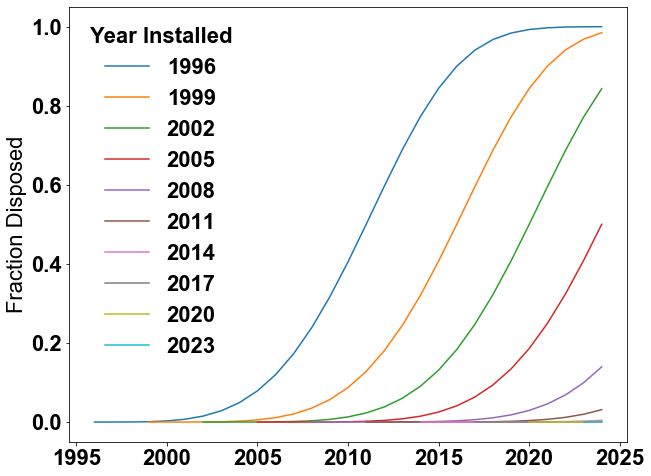

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))
for year, row in df.iterrows():
    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    y = list(map(f, x))
    if year%3 != 1: # doing every 3 years to not have too much stuff.
        continue
    ax.plot(x + year, y, label=year)
ax.legend(frameon=False, title='Year Installed')
ax.set_ylabel('Fraction Disposed')
pass

### Plot: Weibull CDF for each Generation

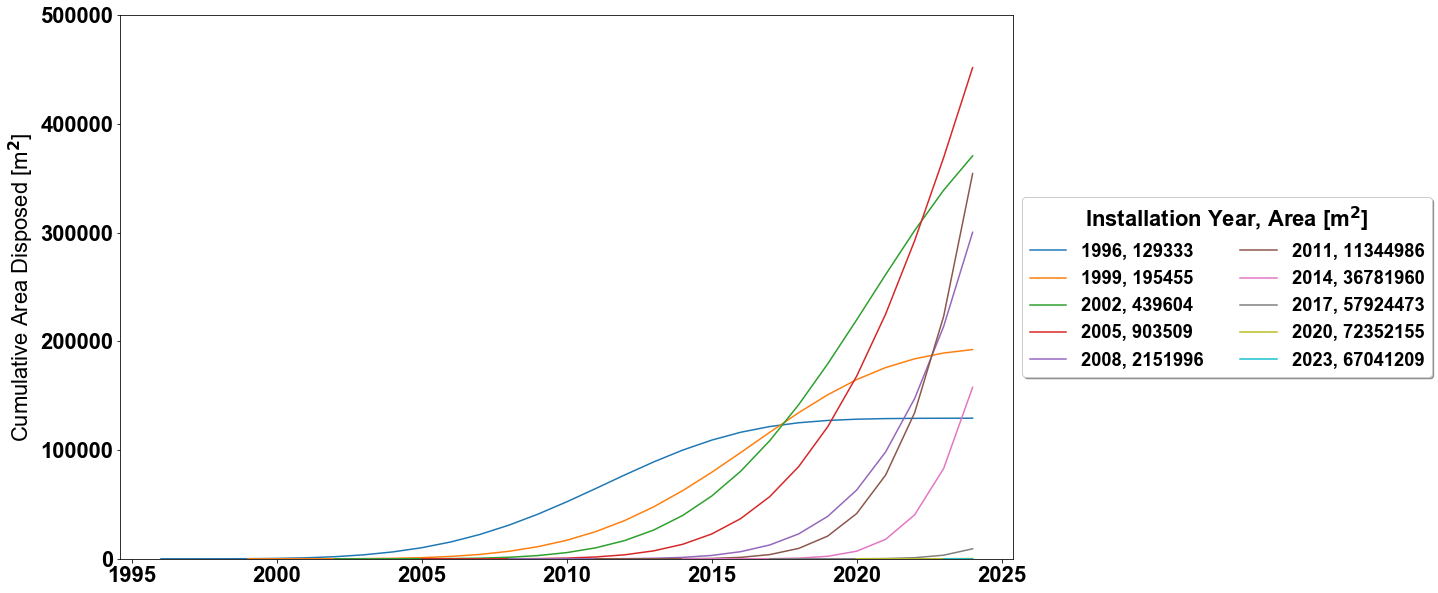

In [44]:
fig, ax = plt.subplots(figsize=(20,10))
for year, row in df.iterrows():
    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    y = list(map(f, x))
    if year%3 != 1:
        continue
    ax.plot(x + year, np.array(y)*row['area'], label=str(year) + ', ' + str(round(row['area'])))
plt.ylim(0, 0.05E7)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title='Installation Year, Area [m$^2$]', loc='center left', fontsize='small', ncol=2, shadow=True, fancybox=True, bbox_to_anchor=(1, 0.5))
#ax.legend(title='year installed', loc='upper center', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(0.5, 1.05))
ax.set_ylabel('Cumulative Area Disposed [m$^2$]')
pass


## PDF Waste by Generation


### Math Check of Tim's Original Function. 


In [45]:
'''
# TIM's Original:


for waste_ingredient in ['glass', 'silver']:
    df[f'waste_{waste_ingredient}'] = 0
    for year, row in df.iterrows():
        df[f'waste_{waste_ingredient}'] += row[f'mass_{waste_ingredient}']*row['disposal_function'](np.clip(df.index - year, 0, np.inf))

#### if I did the math right, this isn't cumulative waste, it's each individual year's waste
fig, axa = plt.subplots(nrows=2)
for index, waste_ingredient in enumerate(['glass', 'silver']):
    ax = axa[index]
    ax.scatter(df.index, df[f'waste_{waste_ingredient}'], label=waste_ingredient)
    ax.set_ylabel(f'{waste_ingredient} waste / kg')

'''
pass


### Changing t[50] and t90 to make hte modules die faster on this test.

Sanity Check for Tim's Method
Rows are each generation. Columns are how that generation produces trash as it ages.
Row [-1] is Tim's original Cumluative Waste on each year from all generations disposed
Row [0] is the sum from each generation's waste calculated independently
Column 2 should be 0, because you can't dispose more trash over all the years for a generation than the original generation installation

In conclusion this Math is not right. It's considering WEIBULL'S CDF and not PDF 
Index(['new_capacity_total', 'new_capacity_silicon', 'efficiency', 'area',
       'mass_glass', 'mass_silver_per_cell', 'n_cells', 'mass_silver', 't50',
       't90', 'disposal_function', 'original_t50', 'original_t90',
       'original_disposal_function', 'TIM_Cum_waste_Area'],
      dtype='object')


,Original Area - Disposed Area (should be 0),Generation Original Area,Generation Disposed Area through Years,1995,1996,1997,1998,1999,2000,2001,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
-1,NaN,NaN,3.624149e+08,0.0,0.022858,2.217388,33.940181,245.304150,1165.805323,4216.802327,...,4.223306e+06,5.616185e+06,7.584298e+06,1.055597e+07,1.527680e+07,2.292357e+07,3.510605e+07,5.362622e+07,8.007425e+07,1.155392e+08
0,NaN,NaN,3.624149e+08,0.0,0.022858,2.217388,33.940181,245.304150,1165.805323,4216.802327,...,4.223306e+06,5.616185e+06,7.584298e+06,1.055597e+07,1.527680e+07,2.292357e+07,3.510605e+07,5.362622e+07,8.007425e+07,1.155392e+08
1995,2.363073e+06,1.267606e+05,2.489834e+06,0.0,0.022858,2.194066,31.675211,210.429100,912.072700,3004.610613,...,1.267606e+05,1.267606e+05,1.267606e+05,1.267606e+05,1.267606e+05,1.267606e+05,1.267606e+05,1.267606e+05,1.267606e+05,1.267606e+05
1996,2.281702e+06,1.293333e+05,2.411035e+06,0.0,0.000000,0.023322,2.238598,32.318100,214.700031,930.584398,...,1.293333e+05,1.293333e+05,1.293333e+05,1.293333e+05,1.293333e+05,1.293333e+05,1.293333e+05,1.293333e+05,1.293333e+05,1.293333e+05
1997,2.433896e+06,1.462500e+05,2.580146e+06,0.0,0.000000,0.000000,0.026373,2.531404,36.545275,242.782574,...,1.462500e+05,1.462500e+05,1.462500e+05,1.462500e+05,1.462500e+05,1.462500e+05,1.462500e+05,1.462500e+05,1.462500e+05,1.462500e+05
1998,2.215953e+06,1.416667e+05,2.357620e+06,0.0,0.000000,0.000000,0.000000,0.025546,2.452072,35.399981,...,1.416667e+05,1.416667e+05,1.416667e+05,1.416667e+05,1.416667e+05,1.416667e+05,1.416667e+05,1.416667e+05,1.416667e+05,1.416667e+05
1999,2.861850e+06,1.954545e+05,3.057305e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.035245,3.383073,...,1.954545e+05,1.954545e+05,1.954545e+05,1.954545e+05,1.954545e+05,1.954545e+05,1.954545e+05,1.954545e+05,1.954545e+05,1.954545e+05
2000,3.153801e+06,2.311828e+05,3.384984e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.041688,...,2.311724e+05,2.311827e+05,2.311828e+05,2.311828e+05,2.311828e+05,2.311828e+05,2.311828e+05,2.311828e+05,2.311828e+05,2.311828e+05
2001,3.779574e+06,2.989691e+05,4.078543e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.984489e+05,2.989556e+05,2.989690e+05,2.989691e+05,2.989691e+05,2.989691e+05,2.989691e+05,2.989691e+05,2.989691e+05,2.989691e+05
2002,5.117880e+06,4.396040e+05,5.557484e+06,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.307097e+05,4.388391e+05,4.395842e+05,4.396039e+05,4.396040e+05,4.396040e+05,4.396040e+05,4.396040e+05,4.396040e+05,4.396040e+05


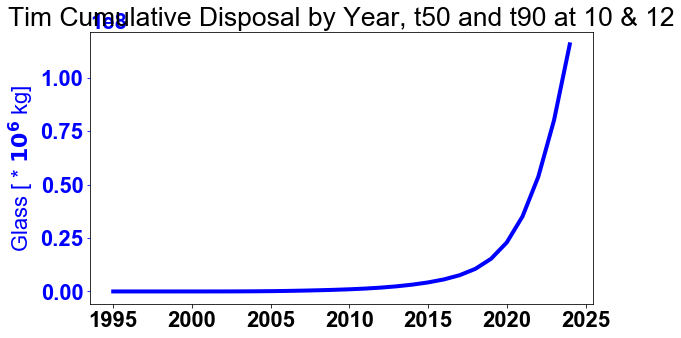

In [46]:
df['original_t50'] = df['t50']
df['original_t90'] = df['t90']
df['original_disposal_function'] = df['disposal_function']
df['t50'] = 10
df['t90'] = 12

df['disposal_function'] = [
    weibull_cdf(**weibull_params({t50: 0.5, t90: 0.9}))
    for t50, t90
    in zip(df['t50'], df['t90'])
]
  
# Cumulative Results Area
df['TIM_Cum_waste_Area'] = 0
for year, row in df.iterrows():
    df['TIM_Cum_waste_Area'] += row['area']*row['disposal_function'](np.clip(df.index - year, 0, np.inf))

# Yearly results
test = []
for year, row in df.iterrows():
    test.append(row['area']*row['disposal_function'](np.clip(df.index - year, 0, np.inf)))

'''
print("Cumulative Area trash")
for i in range (0, len(test[0])):
    print(df['waste_Area'][df.index[i]])
    
'''

# PLOTTING Tim's results
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['TIM_Cum_waste_Area'], 'blue', label='Area Waste', linewidth=4)
ax.set_ylabel('Glass [ * $10^6$ kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
plt.title("Tim Cumulative Disposal by Year, t50 and t90 at " + str(df['t50'].iloc[0])  +  " & "  +  str(df['t90'].iloc[0]))

pass

# Printing Observatinos
print("Sanity Check for Tim's Method")
print("Rows are each generation. Columns are how that generation produces trash as it ages.")
print("Row [-1] is Tim's original Cumluative Waste on each year from all generations disposed")
print("Row [0] is the sum from each generation's waste calculated independently")
print("Column 2 should be 0, because you can't dispose more trash over all the years for a generation than the original generation installation")
print("")
print("In conclusion this Math is not right. It's considering WEIBULL'S CDF and not PDF ")

# Making Table to Show Observations
foo = pd.DataFrame(test, columns = df.index, index = df.index)
foo.loc[0] = foo.sum()
foo.loc[-1] = df['TIM_Cum_waste_Area'].T   # Yearly Cumulative Generation Waste
foo.sort_index(inplace=True)
foo.insert(0, 'Generation Disposed Area through Years', foo.sum(axis=1))
foo.insert(0, 'Generation Original Area', df['area'])
foo.insert(0, 'Original Area - Disposed Area (should be 0)', foo['Generation Disposed Area through Years']-foo['Generation Original Area'])


# CLEANUP
# Revert change to avoid issues later on
df['t50'] = df['original_t50']
df['t90'] = df['original_t90']
df['disposal_function'] = df['original_disposal_function']

print(df.keys())
df.drop(columns=['original_t50', 'original_t90', 'original_disposal_function', 'TIM_Cum_waste_Area'], inplace=True)


# Printing table of observations 
foo




## FIXED PDF Procedure: Sanity Check Plot of Procedure


Sanity Check of PDF for each Generation, with TEST t50 and t90 of  10  &  12 years
Diference with original area:  -2.4473791422351496
Diference with original area:  -135.58467907525483
Diference with original area:  -3003.1894223455747


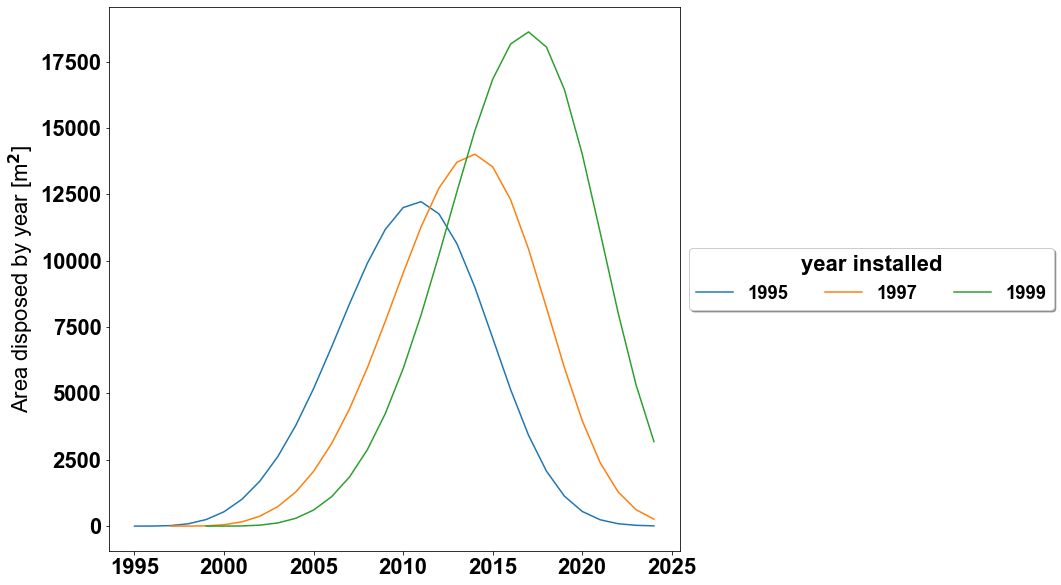

In [47]:
years = [1995, 1997, 1999]
t50 = 10
t90 = 12

print("Sanity Check of PDF for each Generation, with TEST t50 and t90 of ", t50, " & ", t90, "years")

fig, ax = plt.subplots(figsize=(20,10))

for i in range(len(years)):
    year = years[i]
    row = df.loc[year]
    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    y = list(map(f, x))
    res = [0]  # Assuming there is no trash that first year
    i = 1 # Counting from year 1 
    res = res + [j - i for i, j in zip(y[: -1], y[i :])]

    ax.plot(x + year, [element*row['area'] for element in res], label=year)
    ax.legend(frameon=False, title='year installed')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(title='year installed', loc='center left', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(1, 0.5))
    #ax.legend(title='year installed', loc='upper center', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(0.5, 1.05))
    ax.set_ylabel('Area disposed by year [m$^2$]')
    pass

    print ("Diference with original area: ", np.sum([element*row['area'] for element in res])-row['area'])

### Sanity Check: Calculating Waste per Generation for Each Year 

Sanity Check for Silvana's Method
Rows are each generation. Columns are how that generation produces trash as it ages.
Row [-1] is Silvana's Cumluative Waste on each year from all generations disposed
Row [0] is the sum from each generation's waste calculated independently
Column 2 should be 0, because you can't dispose more trash over all the years for a generation than the original generation installation
Later years do not 0 out because generations still have modules Alive by end of 2025

In conclusion this Math IS right. It's considering WEIBULL'S PDF properly 
Index(['new_capacity_total', 'new_capacity_silicon', 'efficiency', 'area',
       'mass_glass', 'mass_silver_per_cell', 'n_cells', 'mass_silver', 't50',
       't90', 'disposal_function', 'original_t50', 'original_t90',
       'original_disposal_function', 'SILVANA_Cum_waste_Area'],
      dtype='object')


,Original Area - Disposed Area (should be 0),Generation Original Area,Generation Disposed Area through Years,1995,1996,1997,1998,1999,2000,2001,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
-1,NaN,NaN,1.155392e+08,0.0,0.023,2.195,31.723,211.364,920.501,3050.997,...,1039392.368,1392879.604,1968112.614,2971669.963,4720836.219,7646767.610,1.218248e+07,1.852017e+07,2.644804e+07,3.546494e+07
0,NaN,NaN,1.155392e+08,0.0,0.023,2.195,31.723,211.364,920.501,3050.997,...,1039392.368,1392879.604,1968112.614,2971669.963,4720836.219,7646767.610,1.218248e+07,1.852017e+07,2.644804e+07,3.546494e+07
1995,-0.0,1.267606e+05,1.267606e+05,0.0,0.023,2.171,29.481,178.754,701.644,2092.538,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1996,0.0,1.293333e+05,1.293333e+05,0.0,0.000,0.023,2.215,30.080,182.382,715.884,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1997,0.0,1.462500e+05,1.462500e+05,0.0,0.000,0.000,0.026,2.505,34.014,206.237,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1998,0.0,1.416667e+05,1.416667e+05,0.0,0.000,0.000,0.000,0.026,2.427,32.948,...,0.032,0.000,0.000,0.000,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1999,0.0,1.954545e+05,1.954545e+05,0.0,0.000,0.000,0.000,0.000,0.035,3.348,...,8.759,0.044,0.000,0.000,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2000,0.0,2.311828e+05,2.311828e+05,0.0,0.000,0.000,0.000,0.000,0.000,0.042,...,391.807,10.360,0.052,0.000,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2001,0.0,2.989691e+05,2.989691e+05,0.0,0.000,0.000,0.000,0.000,0.000,0.000,...,5528.749,506.691,13.398,0.067,0.000,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2002,0.0,4.396040e+05,4.396040e+05,0.0,0.000,0.000,0.000,0.000,0.000,0.000,...,35066.088,8129.470,745.038,19.701,0.099,0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


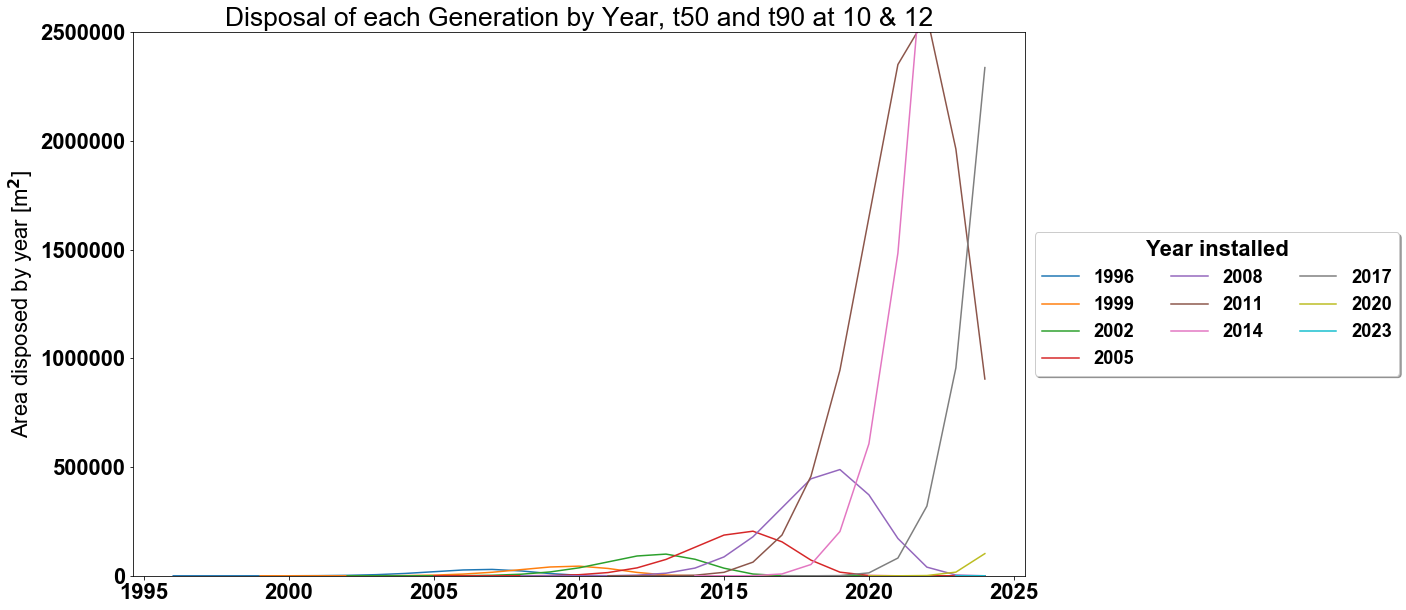

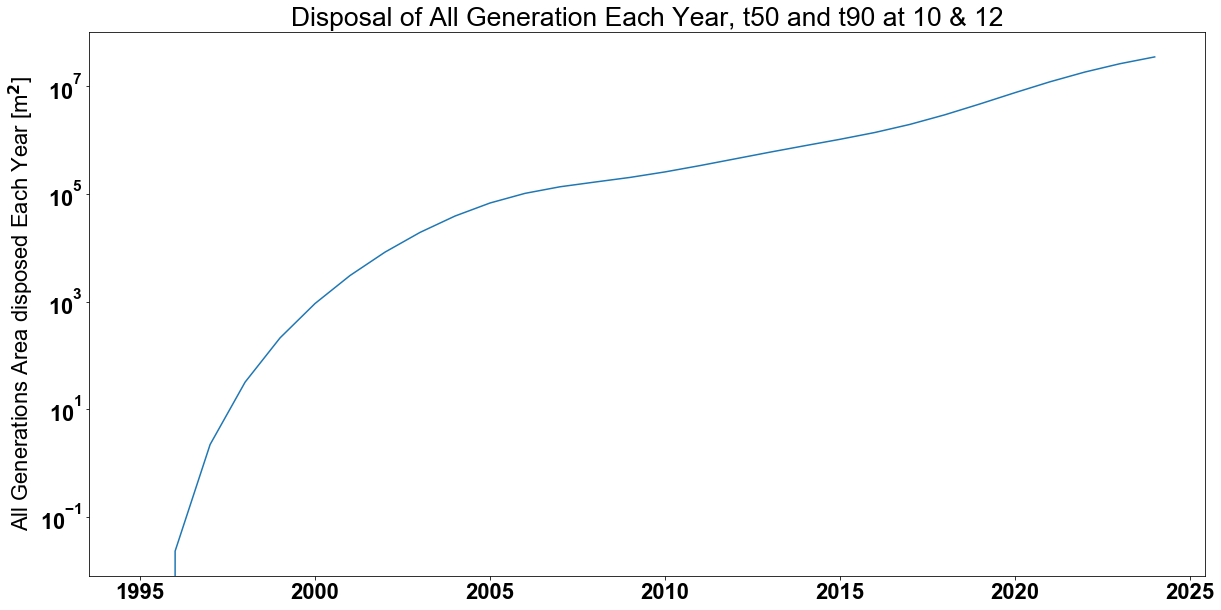

In [48]:
df['original_t50'] = df['t50']
df['original_t90'] = df['t90']
df['original_disposal_function'] = df['disposal_function']
df['t50'] = 10
df['t90'] = 12

df['disposal_function'] = [
    weibull_cdf(**weibull_params({t50: 0.5, t90: 0.9}))
    for t50, t90
    in zip(df['t50'], df['t90'])
]
  

i=1
j=[0]
CDF = []
PDF = []
Area_Disposed_GenbyYear = []
df['SILVANA_Cum_waste_Area'] = 0

fig, ax = plt.subplots(figsize=(20,10))
for year, row in df.iterrows(): 

    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    cdf = list(map(f, x))
    pdf = j
    pdf = pdf + [j - i for i, j in zip(cdf[: -1], cdf[1 :])]
    area_disposed_of_generation_by_year = [element*row['area'] for element in pdf]
    df['SILVANA_Cum_waste_Area'] += area_disposed_of_generation_by_year
    # 
    CDF.append(cdf)
    PDF.append(pdf)
    Area_Disposed_GenbyYear.append(area_disposed_of_generation_by_year)

    if year%3 != 1:
        continue
    ax.plot(x + year, area_disposed_of_generation_by_year, label=year)

#plt.yscale("log")
plt.ylim(0, 0.25E7)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title='Year installed', loc='center left', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(1, 0.5))
#ax.legend(title='year installed', loc='upper center', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(0.5, 1.05))
ax.set_ylabel('Area disposed by year [m$^2$]')
plt.title("Disposal of each Generation by Year, t50 and t90 at " + str(df['t50'].iloc[0])  +  " & "  +  str(df['t90'].iloc[0]))
pass



# Printing Observatinos
print("Sanity Check for Silvana's Method")
print("Rows are each generation. Columns are how that generation produces trash as it ages.")
print("Row [-1] is Silvana's Cumluative Waste on each year from all generations disposed")
print("Row [0] is the sum from each generation's waste calculated independently")
print("Column 2 should be 0, because you can't dispose more trash over all the years for a generation than the original generation installation")
print("Later years do not 0 out because generations still have modules Alive by end of 2025")
print("")
print("In conclusion this Math IS right. It's considering WEIBULL'S PDF properly ")

# Making Table to Show Observations
foo = pd.DataFrame(Area_Disposed_GenbyYear, columns = df.index, index = df.index)
foo.loc[0] = foo.sum()
foo.loc[-1] = df['SILVANA_Cum_waste_Area'].T   # Yearly Cumulative Generation Waste
foo.sort_index(inplace=True)
foo.insert(0, 'Generation Disposed Area through Years', foo.sum(axis=1))
foo.insert(0, 'Generation Original Area', df['area'])
foo.insert(0, 'Original Area - Disposed Area (should be 0)', foo['Generation Disposed Area through Years']-foo['Generation Original Area'])
foo=foo.round(3)

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(df.index, df['SILVANA_Cum_waste_Area'])
#plt.ylim(0, 0.25E7)
plt.yscale("log")
ax.set_ylabel('All Generations Area disposed Each Year [m$^2$]')
plt.title("Disposal of All Generation Each Year, t50 and t90 at " + str(df['t50'].iloc[0])  +  " & "  +  str(df['t90'].iloc[0]))
pass

# CLEANUP
# Revert change to avoid issues later on
df['t50'] = df['original_t50']
df['t90'] = df['original_t90']
df['disposal_function'] = df['original_disposal_function']
print(df.keys())
df.drop(columns=['original_t50', 'original_t90', 'original_disposal_function'], inplace=True)

# Printing Table
foo.round({'Original Area - Disposed Area (should be 0)':0})

# Calculating Waste Correctly for each Generation and Cumulative

,new_capacity_total,new_capacity_silicon,efficiency,area,mass_glass,mass_silver_per_cell,n_cells,mass_silver,t50,t90,...,Disposed_on_Year_2015,Disposed_on_Year_2016,Disposed_on_Year_2017,Disposed_on_Year_2018,Disposed_on_Year_2019,Disposed_on_Year_2020,Disposed_on_Year_2021,Disposed_on_Year_2022,Disposed_on_Year_2023,Disposed_on_Year_2024
1995,9.000000e+06,9.000000e+06,0.071000,1.267606e+05,1.109155e+06,0.000850,5.208767e+06,4427.452288,15,20.0,...,7079.104684,5139.641911,3419.998231,2069.350573,1129.004041,550.446906,237.558644,89.849082,29.469522,8.290050
1996,9.700000e+06,9.700000e+06,0.075000,1.293333e+05,1.131667e+06,0.000800,5.314486e+06,4251.588867,15,20.0,...,9184.716790,7222.784290,5243.957606,3489.411528,2111.350725,1151.918642,561.618939,242.380204,91.672686,30.067644
1997,1.170000e+07,1.170000e+07,0.080000,1.462500e+05,1.279688e+06,0.000800,6.009615e+06,4807.692308,16,21.0,...,13534.767610,12293.060894,10435.685849,8224.559192,5973.211881,3965.349128,2385.143960,1287.654429,617.646908,260.409015
1998,1.190000e+07,1.190000e+07,0.084000,1.416667e+05,1.239583e+06,0.000750,5.821280e+06,4365.959895,16,21.0,...,13572.806254,13110.601103,11907.808273,10108.641563,7966.809474,5786.017206,3841.078928,2310.395859,1247.300586,598.290453
1999,1.720000e+07,1.720000e+07,0.088000,1.954545e+05,1.710227e+06,0.000700,8.031498e+06,5622.048891,17,22.0,...,16838.997915,18164.507541,18618.911440,18047.374592,16449.043334,14006.052492,11060.436323,8035.236157,5322.809543,3184.219423
2000,2.150000e+07,2.150000e+07,0.093000,2.311828e+05,2.022849e+06,0.000650,9.499622e+06,6174.754159,17,22.0,...,17613.666241,19917.094308,21484.901393,22022.368370,21346.357045,19455.857707,16566.298647,13082.236511,9504.042766,6295.796234
2001,2.900000e+07,2.900000e+07,0.097000,2.989691e+05,2.615979e+06,0.000650,1.228505e+07,7985.285047,18,23.0,...,15518.604568,19083.916790,22539.258642,25507.188376,27567.368446,28332.658704,27548.260894,25187.550983,21505.567468,17013.590817
2002,4.440000e+07,4.440000e+07,0.101000,4.396040e+05,3.846535e+06,0.000600,1.806394e+07,10838.361943,18,23.0,...,17842.766593,22818.547680,28060.980823,33141.713595,37505.755854,40535.043504,41660.325882,40506.947770,37035.761207,31621.774657
2003,6.300000e+07,6.300000e+07,0.106000,5.943396e+05,5.200472e+06,0.000550,2.442224e+07,13432.231774,18,23.0,...,18138.174312,24123.220260,30850.420467,37938.131263,44807.224971,50707.361147,54802.924064,56324.293215,54764.938947,50071.933656
2004,1.008000e+08,1.008000e+08,0.110000,9.163636e+05,8.018182e+06,0.000500,3.765465e+07,18827.326520,19,24.0,...,14337.045673,20464.790007,28073.111717,37092.897821,47243.528932,57973.887465,68432.748831,77498.806332,83900.010383,86435.606072


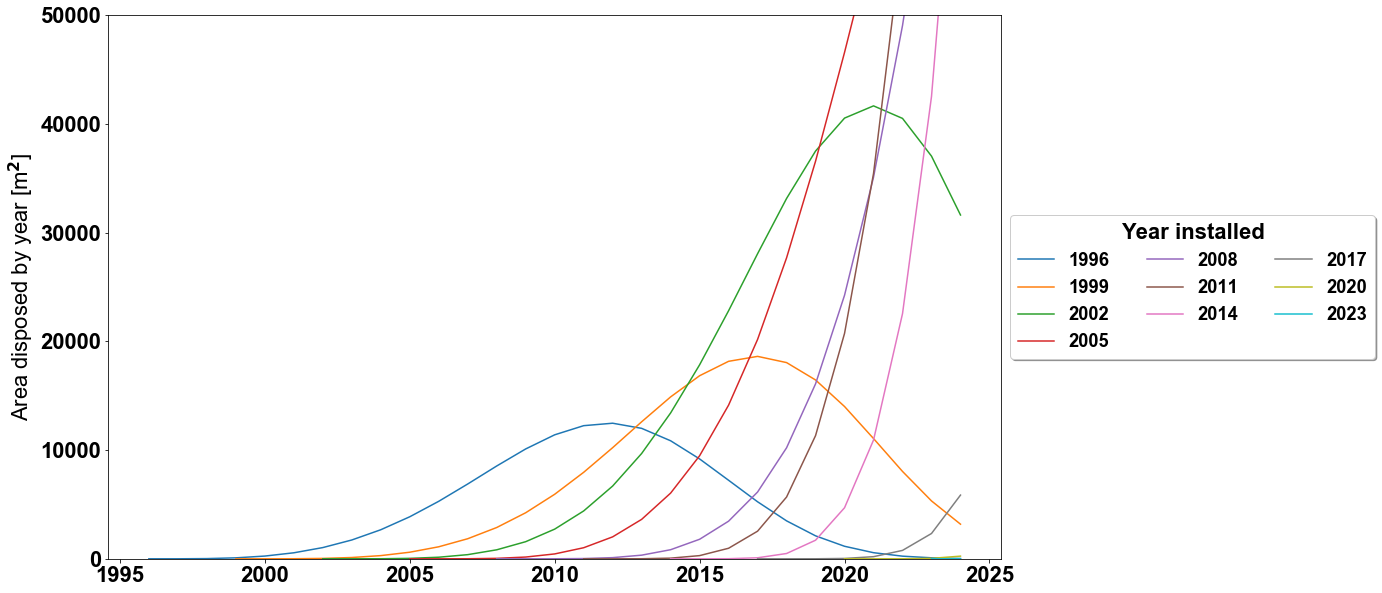

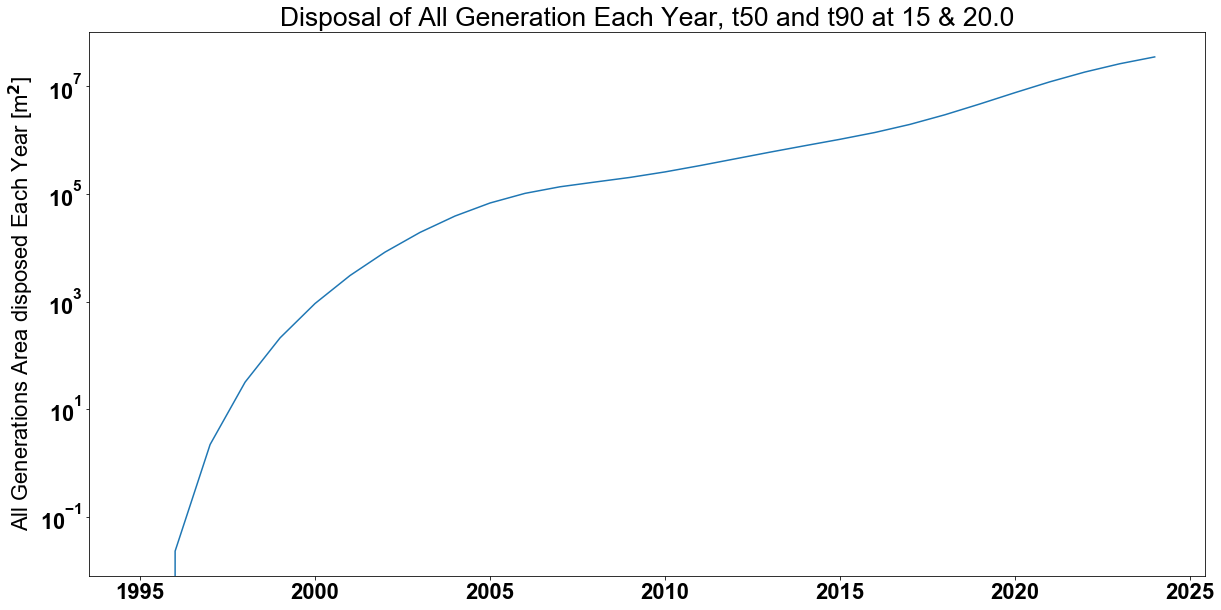

In [49]:
CDF = []
PDF = []
Area_Disposed_GenbyYear = []
df['Cumulative_Waste_Area'] = 0

fig, ax = plt.subplots(figsize=(20,10))
for year, row in df.iterrows(): 

    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    cdf = list(map(f, x))
    pdf = [0]
    pdf = pdf + [j - i for i, j in zip(cdf[: -1], cdf[1 :])]
    area_disposed_of_generation_by_year = [element*row['area'] for element in pdf]
    df['Cumulative_Waste_Area'] += area_disposed_of_generation_by_year
    # 
    CDF.append(cdf)
    PDF.append(pdf)
    Area_Disposed_GenbyYear.append(area_disposed_of_generation_by_year)

    if year%3 != 1:
        continue
    ax.plot(x + year, area_disposed_of_generation_by_year, label=year)

#plt.yscale("log")
plt.ylim(0, 0.05E6)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title='Year installed', loc='center left', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(1, 0.5))
#ax.legend(title='year installed', loc='upper center', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(0.5, 1.05))
ax.set_ylabel('Area disposed by year [m$^2$]')

pass

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(df.index, df['SILVANA_Cum_waste_Area'])
#plt.ylim(0, 0.25E7)
plt.yscale("log")
ax.set_ylabel('All Generations Area disposed Each Year [m$^2$]')
plt.title("Disposal of All Generation Each Year, t50 and t90 at " + str(df['t50'].iloc[0])  +  " & "  +  str(df['t90'].iloc[0]))
pass

# Making Table to Show Observations
WasteGenerationbyYear = pd.DataFrame(Area_Disposed_GenbyYear, columns = df.index, index = df.index)
WasteGenerationbyYear = WasteGenerationbyYear.add_prefix("Disposed_on_Year_")
df.join(WasteGenerationbyYear)


In [51]:
print("SANITY CHECK OF RESULTS")
print("Sum of WasteGenerationbyYear")
print(WasteGenerationbyYear.sum(axis=0))
print("df [ 'Cumulative_Waste_Area']")
print(df['Cumulative_Waste_Area'])

SANITY CHECK OF RESULTS
Sum of WasteGenerationbyYear
Disposed_on_Year_1995    0.000000e+00
Disposed_on_Year_1996    1.085881e+00
Disposed_on_Year_1997    1.961045e+01
Disposed_on_Year_1998    1.061223e+02
Disposed_on_Year_1999    3.455216e+02
Disposed_on_Year_2000    8.543147e+02
Disposed_on_Year_2001    1.779854e+03
Disposed_on_Year_2002    3.297691e+03
Disposed_on_Year_2003    5.606975e+03
Disposed_on_Year_2004    8.920323e+03
Disposed_on_Year_2005    1.345476e+04
Disposed_on_Year_2006    1.942034e+04
Disposed_on_Year_2007    2.700461e+04
Disposed_on_Year_2008    3.636074e+04
Disposed_on_Year_2009    4.760509e+04
Disposed_on_Year_2010    6.083692e+04
Disposed_on_Year_2011    7.618287e+04
Disposed_on_Year_2012    9.386635e+04
Disposed_on_Year_2013    1.142935e+05
Disposed_on_Year_2014    1.381543e+05
Disposed_on_Year_2015    1.665405e+05
Disposed_on_Year_2016    2.010702e+05
Disposed_on_Year_2017    2.440293e+05
Disposed_on_Year_2018    2.985629e+05
Disposed_on_Year_2019    3.689753e+

In [52]:
df.keys()

Index(['new_capacity_total', 'new_capacity_silicon', 'efficiency', 'area',
       'mass_glass', 'mass_silver_per_cell', 'n_cells', 'mass_silver', 't50',
       't90', 'disposal_function', 'SILVANA_Cum_waste_Area',
       'Cumulative_Waste_Area'],
      dtype='object')

In [ ]:
CDF = []
PDF = []
Area_Disposed_GenbyYear = []
df['Cumulative_Waste_Glass'] = 0

fig, ax = plt.subplots(figsize=(20,10))
for year, row in df.iterrows(): 

    t50, t90 = row['t50'], row['t90']
    f = weibull_cdf(**weibull_params({t50: 0.50, t90: 0.90}))
    x = np.clip(df.index - year, 0, np.inf)
    cdf = list(map(f, x))
    pdf = [0]
    pdf = pdf + [j - i for i, j in zip(cdf[: -1], cdf[1 :])]
    area_disposed_of_generation_by_year = [element*row['mass_glass'] for element in pdf]
    df['Cumulative_Waste_Glass'] += area_disposed_of_generation_by_year
    # 
    CDF.append(cdf)
    PDF.append(pdf)
    Area_Disposed_GenbyYear.append(area_disposed_of_generation_by_year)


    ax.plot(x + year, area_disposed_of_generation_by_year, label=year)

#plt.yscale("log")
plt.ylim(0, 0.05E6)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(title='Year installed', loc='center left', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(1, 0.5))
#ax.legend(title='year installed', loc='upper center', fontsize='small', ncol=3, shadow=True, fancybox=True, bbox_to_anchor=(0.5, 1.05))
ax.set_ylabel('Area disposed by year [m$^2$]')

pass

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(df.index, df['SILVANA_Cum_waste_Area'])
#plt.ylim(0, 0.25E7)
plt.yscale("log")
ax.set_ylabel('All Generations Area disposed Each Year [m$^2$]')
plt.title("Disposal of All Generation Each Year, t50 and t90 at " + str(df['t50'].iloc[0])  +  " & "  +  str(df['t90'].iloc[0]))
pass

# Making Table to Show Observations
WasteGenerationbyYear = pd.DataFrame(Area_Disposed_GenbyYear, columns = df.index, index = df.index)
WasteGenerationbyYear = WasteGenerationbyYear.add_prefix("Disposed_on_Year_")
df.join(WasteGenerationbyYear)


## Waste calculations

### Mass of waste ingredients

In [ ]:
# if I did the math right, this isn't cumulative waste, it's each individual year's waste
fig, axa = plt.subplots(nrows=2)
for index, waste_ingredient in enumerate(['glass', 'silver']):
    ax = axa[index]
    ax.scatter(df.index, df[f'waste_{waste_ingredient}'], label=waste_ingredient)
    ax.set_ylabel(f'{waste_ingredient} waste / kg')
pass

## Installed Capacity

Installed Capacity for each year is the Existing Installations + New Installations - Decommisionings 

In [ ]:
'''
for installedCapacity_ingredient in ['glass', 'silver']:
    df[f'installedCapacity_{installedCapacity_ingredient}'] = 0.0
    df[f'installedCapacity_{installedCapacity_ingredient}'][df.index[0]] =  df[f'mass_{installedCapacity_ingredient}'][df.index[0]] - df[f'waste_{waste_ingredient}'][df.index[0]]
    for i in range (1, len(df)):
        year = df.index[i]
        prevyear = df.index[i-1]
        df[f'installedCapacity_{installedCapacity_ingredient}'][year] = df[f'installedCapacity_{installedCapacity_ingredient}'][prevyear]+df[f'mass_{installedCapacity_ingredient}'][year] - df[f'waste_{waste_ingredient}'][year]

'''

In [ ]:
df['installedCapacity_glass'] = 0.0
df['installedCapacity_glass'][df.index[0]] =  df[f'mass_glass'][df.index[0]] - df[f'waste_glass'][df.index[0]]
for i in range (1, len(df)):
    year = df.index[i]
    prevyear = df.index[i-1]
    df[f'installedCapacity_glass'][year] = (df[f'installedCapacity_glass'][prevyear]+
                                           df[f'mass_glass'][year] - df['waste_glass'][year])
    
df['installedCapacity_silver'] = 0.0
df['installedCapacity_silver'][df.index[0]] =  df[f'mass_silver'][df.index[0]] - df[f'waste_silver'][df.index[0]]
for i in range (1, len(df)):
    year = df.index[i]
    prevyear = df.index[i-1]
    df[f'installedCapacity_silver'][year] = (df[f'installedCapacity_silver'][prevyear]+
                                           df[f'mass_silver'][year] - df['waste_silver'][year])

In [ ]:
# if I did the math right, this isn't cumulative waste, it's each individual year's waste
fig, axa = plt.subplots(nrows=2)
for index, installedCapacity_ingredient in enumerate(['glass', 'silver']):
    ax = axa[index]
    ax.scatter(df.index, df[f'installedCapacity_{installedCapacity_ingredient}'], label=installedCapacity_ingredient)
    ax.set_ylabel(f'{installedCapacity_ingredient} waste / kg')
pass

In [ ]:
fig, ax = plt.subplots(figsize=(9, 5))
plt.plot(df.index, df['installedCapacity_glass']/1000000, 'blue', label='Glass', linewidth=4)
ax.set_ylabel('Glass [ * $10^6$ kg]', color='blue')
ax.tick_params(axis='y', colors='blue')
ax2=ax.twinx()
plt.title("Installed Capacity")
ax2.plot(df.index, df['installedCapacity_silver']/1000000, 'red', label='silver', linewidth=4)
ax2.set_ylabel('Silver [ * $10^6$ kg]', color='red')
ax2.tick_params(axis='y', colors='red')
pass


In [ ]:
df[f'installedCapacity_{installedCapacity_ingredient}'] = 0
df[f'installedCapacity_{installedCapacity_ingredient}'][df.index[0]] =  df[f'mass_{installedCapacity_ingredient}'][df.index[0]] - df[f'waste_{waste_ingredient}'][df.index[0]]
for i in range (1, len(df)):
    year = df.index[i]
    prevyear = year = df.index[i-1]
    df[f'installedCapacity_{installedCapacity_ingredient}'][year] = df[f'installedCapacity_{installedCapacity_ingredient}'][prevyear]+df[f'mass_{installedCapacity_ingredient}'][year] - df[f'waste_{waste_ingredient}'][year]

## Waste from Feedstock

In development

In [ ]:
df['efficiency_manufacturing_glass'] = []   # in %
df['efficiency_manufacturing_silver'] = []  # in %

for ingredient in ['glass', 'silver']:
    df[f'feedstock_waste_{ingredient}'] = df[f'mass_{installedCapacity_ingredient}'][year]*(100-df['efficiency_manufacturing_glass'])/100
    df[f'feedstock_mass_{ingredient}'] = df[f'mass_{installedCapacity_ingredient}'][year]*100/df['efficiency_manufacturing_glass'])


## Waste from Recycling
Also in development

In [ ]:
df['Wc_Waste_recicled_silver'] = []  # in %
df['Wc_Waste_recicled_glass'] = []  # in %

df['efficiency_recyling_silver'] = []  # in %
df['efficiency_recyling_glass'] = []  # in %

for ingredient in ['glass', 'silver']:
    df[f'recycled_{ingredient}'] = df[f'waste_{ingredient}']*df[f'percentage_waste_recicled_{ingredient}']/100
    df[f'recyling_waste_{ingredient}'] = df[f'recycled_{ingredient}'] * 100 / df['efficiency_recyling_{ingredient}']  
    
    
    (100-df['efficiency_manufacturing_glass'])/100
    df[f'waste_waste_{ingredient}'] =  df[f'waste_{ingredient}']-df[f'recycled_{ingredient}'] _ 
